In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

## Step 1: Get data and set their indexs to datetime.

In [5]:
df1 = pd.read_excel(r'C:\Users\xuany\Downloads\price_data.xlsx')
df1.drop(index=0,inplace=True)
df1.reset_index(drop=True,inplace=True)
df1['datetime'] = pd.to_datetime(df1['Unnamed: 0'], format = '%Y-%m-%d %H:%M:%S')
df1 = df1.set_index(['datetime'])

df2 = pd.read_csv(r'C:\Users\xuany\Downloads\kospi_garch_variables_2000.csv')
df2['datetime'] = pd.to_datetime(df2['date'], format = '%Y-%m-%d')
df2 = df2.set_index(['datetime'])

df = pd.concat([df1, df2], axis=1, join_axes=[df1.index])

C:\Users\xuany\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  # This is added back by InteractiveShellApp.init_path()


## Step2: Calculate rolling volatility based on LogReturn

In [6]:
variable_list = ['KOSPI2 Index', 'garch_cond_vol', 'garch_resid', 'egarch_cond_vol','egarch_std_resid', 'egarch_asymmetric', 'ewma_cond_vol', 'ewma_resid']

training_set = df[variable_list].copy()

training_set = training_set.dropna(how='any')

log_return = np.array([np.log(123.86)-np.log(133.66)])

b = np.log(np.array(training_set['KOSPI2 Index'][:-1].values).astype('float')) - np.log(np.array(training_set['KOSPI2 Index'][1:].values).astype('float'))
training_set['log_return'] = np.append(log_return,b)
vol = training_set['log_return']
roller = vol.rolling(22)
volList = roller.std(ddof=0)

## Step3: Split data into training and testing set

In [8]:
training_set['Volatility'] = pd.DataFrame(volList)
training_set = training_set.dropna(how='any')


train_size = int(len(training_set) * 2/3)
test_size = len(training_set) - train_size


# sc = MinMaxScaler()
variable_list = ['KOSPI2 Index', 'garch_cond_vol', 'garch_resid', 'egarch_cond_vol','egarch_std_resid', 'egarch_asymmetric',
                 'ewma_cond_vol', 'ewma_resid','log_return','Volatility']
variable_list_x = ['KOSPI2 Index', 'garch_cond_vol', 'garch_resid', 'egarch_cond_vol','egarch_std_resid', 'egarch_asymmetric',
                 'ewma_cond_vol', 'ewma_resid','log_return']

# training_set_train_x = sc.fit_transform(training_set[variable_list_x][:train_size])
# training_set_test_x = sc.transform(training_set[variable_list_x][train_size:])
# training_set_x = np.append(training_set_train_x,training_set_test_x,axis = 0)
# training_set_train_y = sc.fit_transform(np.array([training_set['log_return'][:train_size]]).T)
# training_set_test_y = sc.transform(np.array([training_set['log_return'][train_size:]]).T)
# training_set_y = np.append(training_set_train_y,training_set_test_y,axis = 0)
# training_set = np.append(training_set_x,training_set_y,axis = 1)
# training_set = pd.DataFrame(training_set,columns = variable_list)

print(training_set[:10])

           KOSPI2 Index  garch_cond_vol  garch_resid  egarch_cond_vol  \
datetime                                                                
2000-02-07       122.09        7.179522     0.000581         1.930781   
2000-02-08       120.79        6.689499     0.000355         1.813907   
2000-02-09       122.93        6.617722     0.000811         1.756957   
2000-02-10       121.89        6.242746     0.000440         1.733072   
2000-02-11        120.4        5.985990     0.000778         1.656488   
2000-02-14       114.94        5.626562     0.000835         1.618528   
2000-02-15       110.62        5.349765     0.001440         1.620369   
2000-02-16       110.52        6.443731     0.001282         1.957245   
2000-02-17       112.79        6.999706     0.000669         2.148243   
2000-02-18       110.45        6.510244     0.000410         2.025033   

            egarch_std_resid  egarch_asymmetric  ewma_cond_vol  ewma_resid  \
datetime                                     

In [9]:
for var in variable_list_x:
    training_set[var] /= max(training_set[var])-min(training_set[var])

In [10]:
def sliding_windows(data,var_list, seq_length):
    x = []
    y = []

    for i in range(len(data['Volatility'])-2*seq_length-1):

        _x = np.array(data[var_list][i:(i+seq_length)])
        _y = data['Volatility'][i+2*seq_length]

        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [11]:
def data_prepare(data,var_list, seq_length,train_size=3315):
    x, y = sliding_windows(training_set,var_list, seq_length)

    x = x.astype(np.float64)
    y = y.astype(np.float64)
    y = np.array([y]).T
    dataX = Variable(torch.Tensor(x))
    dataY = Variable(torch.Tensor(y))
    # print(dataY)
    trainX = Variable(torch.Tensor(x[:train_size]))
    trainY = Variable(torch.Tensor(y[:train_size]))

    testX = Variable(torch.Tensor(x[train_size:]))
    testY = Variable(torch.Tensor(y[train_size:]))
    
    return dataX,dataY,trainX,trainY,testX,testY

In [12]:
var_list = ['Volatility','KOSPI2 Index', 'garch_cond_vol','garch_resid', 'egarch_cond_vol', 'egarch_std_resid', 
            'egarch_asymmetric','ewma_cond_vol', 'ewma_resid']
seq_length = 22

dataX,dataY,trainX,trainY,testX,testY = data_prepare(training_set,var_list, seq_length)

## Step4: Define the model

In [13]:
## l1loss, batch size = whole data
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):

        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [14]:
def Error_stat(dataY_plot,data_predict,train_size):
    MAE_test = sum(abs(dataY_plot[train_size:] - data_predict[train_size:]))/(len(dataY_plot)-train_size)
    MSE_test = sum((dataY_plot[train_size:] - data_predict[train_size:])**2)/(len(dataY_plot)-train_size)
    HMAE_test = sum(abs(1-dataY_plot[train_size:]/data_predict[train_size:]))/(len(dataY_plot)-train_size)
    HMSE_test = sum((1-dataY_plot[train_size:]/data_predict[train_size:])**2)/(len(dataY_plot)-train_size)
    MAE_train = sum(abs(dataY_plot[:train_size] - data_predict[:train_size]))/train_size
    MSE_train = sum((dataY_plot[:train_size] - data_predict[:train_size])**2)/train_size
    HMAE_train = sum(abs(1-dataY_plot[:train_size]/data_predict[:train_size]))/train_size
    HMSE_train = sum((1-dataY_plot[:train_size]/data_predict[:train_size])**2)/train_size
    MAE_overall = sum(abs(dataY_plot - data_predict))/len(dataY_plot)
    MSE_overall = sum((dataY_plot - data_predict)**2)/len(dataY_plot)
    HMAE_overall = sum(abs(1-dataY_plot/data_predict))/len(dataY_plot)
    HMSE_overall = sum((1-dataY_plot/data_predict)**2)/len(dataY_plot)
    final_stat = pd.DataFrame([['','Test','Train','Overall'],
                               ['MAE',MAE_test*100,MAE_train*100,MAE_overall*100],
                               ['MSE',MSE_test*10000,MSE_train*10000,MSE_overall*10000],
                               ['HMAE',HMAE_test,HMAE_train,HMAE_overall],
                               ['HMSE',HMSE_test,HMSE_train,HMSE_overall]])
    return final_stat

## Step5: Performances of hybrid models with different input parameters

## 3-Garch-Type-Parameter

Epoch: 0, loss: 0.08893
Epoch: 20, loss: 0.01459
Epoch: 40, loss: 0.00625
Epoch: 60, loss: 0.00399
Epoch: 80, loss: 0.00385
Epoch: 100, loss: 0.00381
Epoch: 120, loss: 0.00379
Epoch: 140, loss: 0.00379
Epoch: 160, loss: 0.00378
Epoch: 180, loss: 0.00378


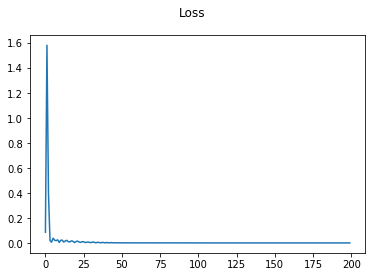

In [15]:
var_list = ['Volatility','KOSPI2 Index', 'garch_cond_vol','garch_resid', 'egarch_cond_vol', 'egarch_std_resid', 
            'egarch_asymmetric','ewma_cond_vol', 'ewma_resid']
seq_length = 22

dataX,dataY,trainX,trainY,testX,testY = data_prepare(training_set,var_list, seq_length)
num_epochs = 200
learning_rate = 0.01
input_size = len(var_list)
hidden_size = input_size
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.L1Loss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

loss_list = []


# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss_list.append(loss.item())
    loss.backward()
    
    optimizer.step()
    if epoch % 20 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        
plt.plot(loss_list)
plt.suptitle('Loss')
plt.show()

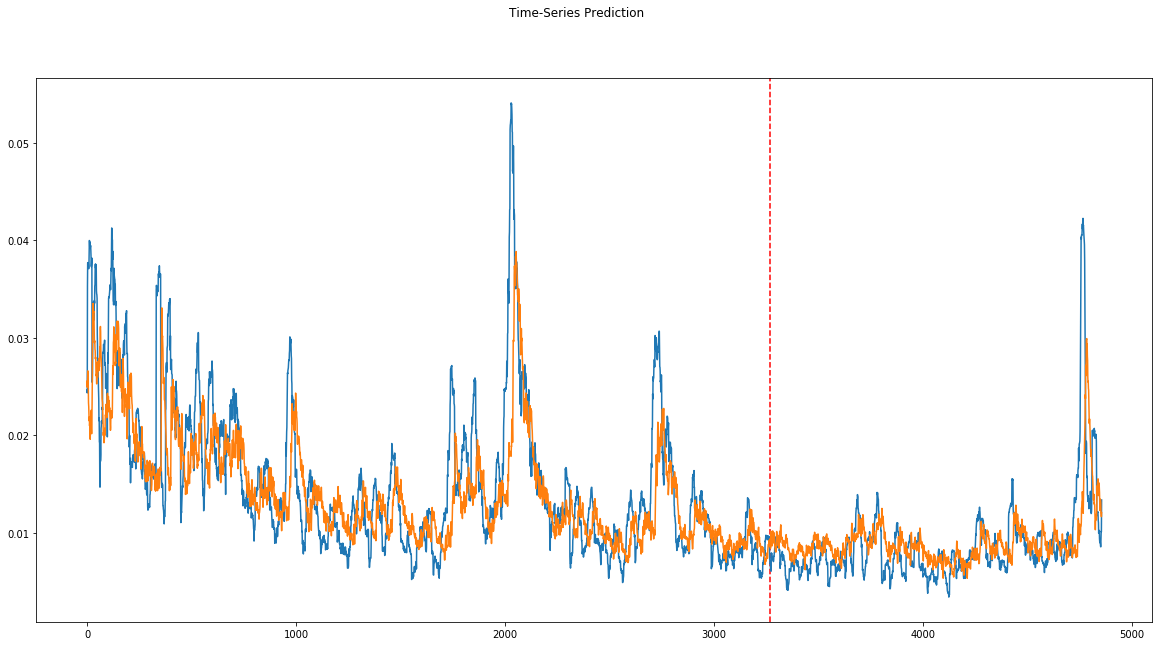

In [16]:
lstm.eval()
# print(dataX[0])
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

plt.figure(figsize=(20,10))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

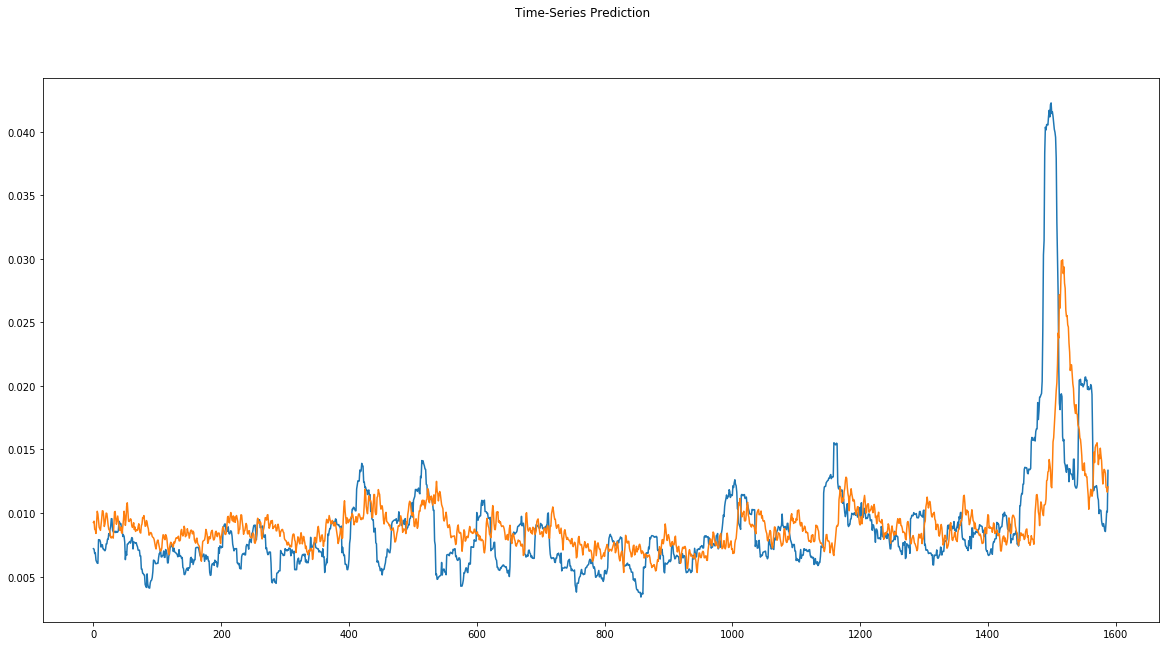

In [17]:

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(20,10))

plt.plot(dataY_plot[train_size:])
plt.plot(data_predict[train_size:])
plt.suptitle('Time-Series Prediction')
plt.show()

In [18]:
table = Error_stat(dataY_plot,data_predict,train_size)
table

,0,1,2,3
0,,Test,Train,Overall
1,MAE,[0.24089156],[0.37765518],[0.33289367]
2,MSE,[0.17286393],[0.3253539],[0.27544543]
3,HMAE,[0.24604812],[0.2642126],[0.2582671]
4,HMSE,[0.13531989],[0.1452363],[0.14199068]


## Garch+EGarch

Epoch: 0, loss: 0.11980
Epoch: 20, loss: 0.00822
Epoch: 40, loss: 0.00485
Epoch: 60, loss: 0.00396
Epoch: 80, loss: 0.00383
Epoch: 100, loss: 0.00381
Epoch: 120, loss: 0.00381
Epoch: 140, loss: 0.00380
Epoch: 160, loss: 0.00379
Epoch: 180, loss: 0.00379


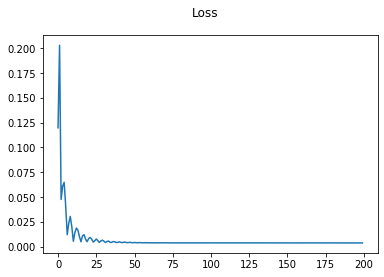

In [19]:
var_list = ['Volatility','KOSPI2 Index', 'garch_cond_vol','garch_resid', 'egarch_cond_vol', 'egarch_std_resid']
seq_length = 22

dataX,dataY,trainX,trainY,testX,testY = data_prepare(training_set,var_list, seq_length)
num_epochs = 200
learning_rate = 0.01
input_size = len(var_list)
hidden_size = 22*input_size
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.L1Loss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

loss_list = []


# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss_list.append(loss.item())
    loss.backward()
    
    optimizer.step()
    if epoch % 20 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        
plt.plot(loss_list)
plt.suptitle('Loss')
plt.show()

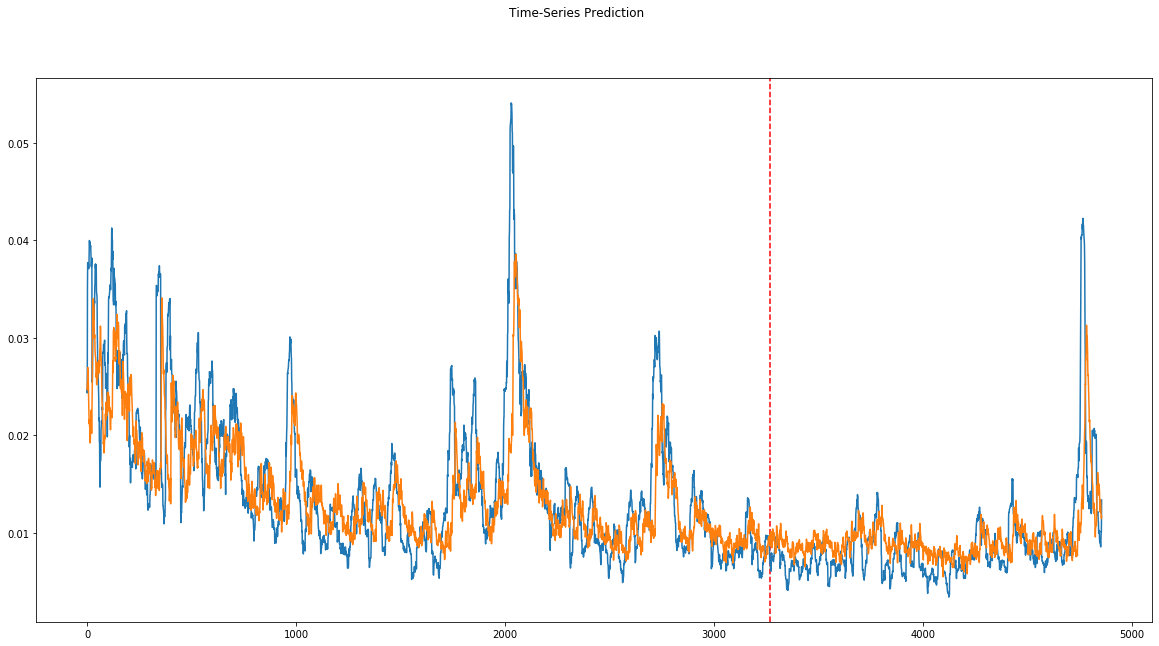

In [20]:
lstm.eval()
# print(dataX[0])
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

plt.figure(figsize=(20,10))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

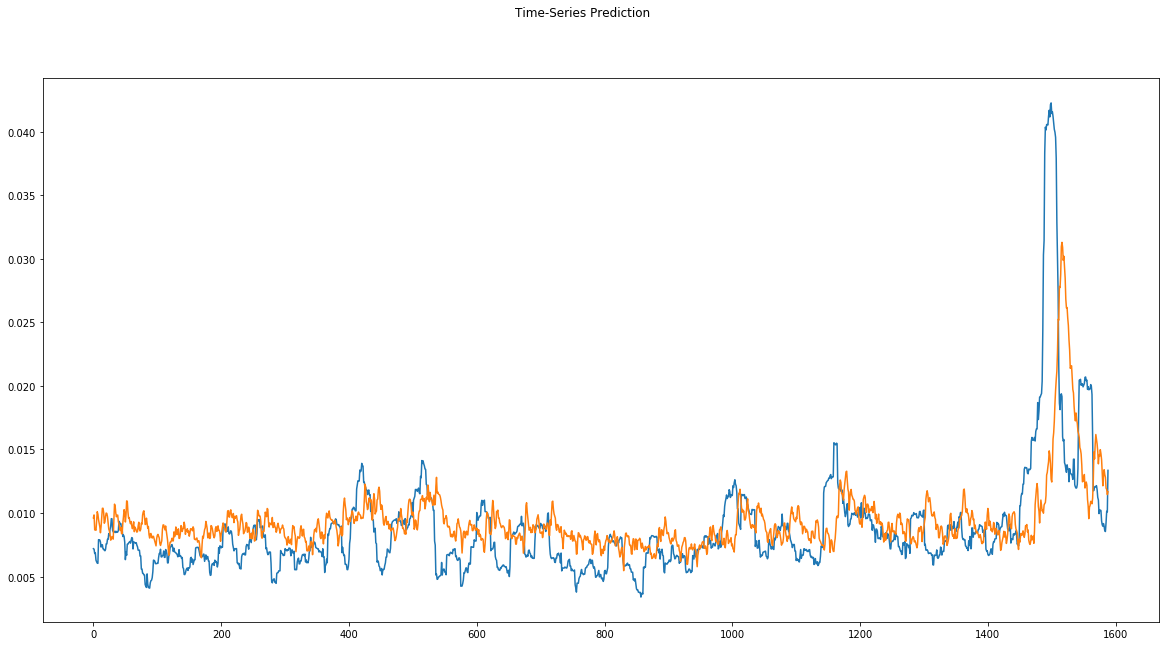

In [21]:

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(20,10))

plt.plot(dataY_plot[train_size:])
plt.plot(data_predict[train_size:])
plt.suptitle('Time-Series Prediction')
plt.show()

In [22]:
table = Error_stat(dataY_plot,data_predict,train_size)
table

,0,1,2,3
0,,Test,Train,Overall
1,MAE,[0.2511931],[0.37781426],[0.3363723]
2,MSE,[0.17611219],[0.32502496],[0.276287]
3,HMAE,[0.25072753],[0.263552],[0.25935495]
4,HMSE,[0.13228886],[0.1445879],[0.14056234]


## Garch + EWMA

Epoch: 0, loss: 0.00466
Epoch: 20, loss: 0.00434
Epoch: 40, loss: 0.00422
Epoch: 60, loss: 0.00388
Epoch: 80, loss: 0.00380
Epoch: 100, loss: 0.00376
Epoch: 120, loss: 0.00374
Epoch: 140, loss: 0.00373
Epoch: 160, loss: 0.00372
Epoch: 180, loss: 0.00371


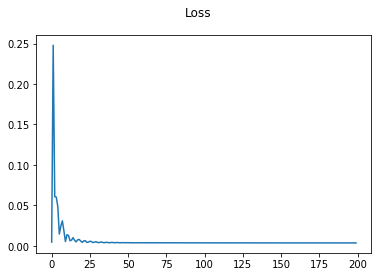

In [23]:
var_list = ['Volatility','KOSPI2 Index', 'garch_cond_vol','garch_resid', 'ewma_cond_vol', 'ewma_resid']
seq_length = 22

dataX,dataY,trainX,trainY,testX,testY = data_prepare(training_set,var_list, seq_length)
num_epochs = 200
learning_rate = 0.01
input_size = len(var_list)
hidden_size = input_size*seq_length
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.L1Loss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

loss_list = []


# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss_list.append(loss.item())
    loss.backward()
    
    optimizer.step()
    if epoch % 20 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        
plt.plot(loss_list)
plt.suptitle('Loss')
plt.show()

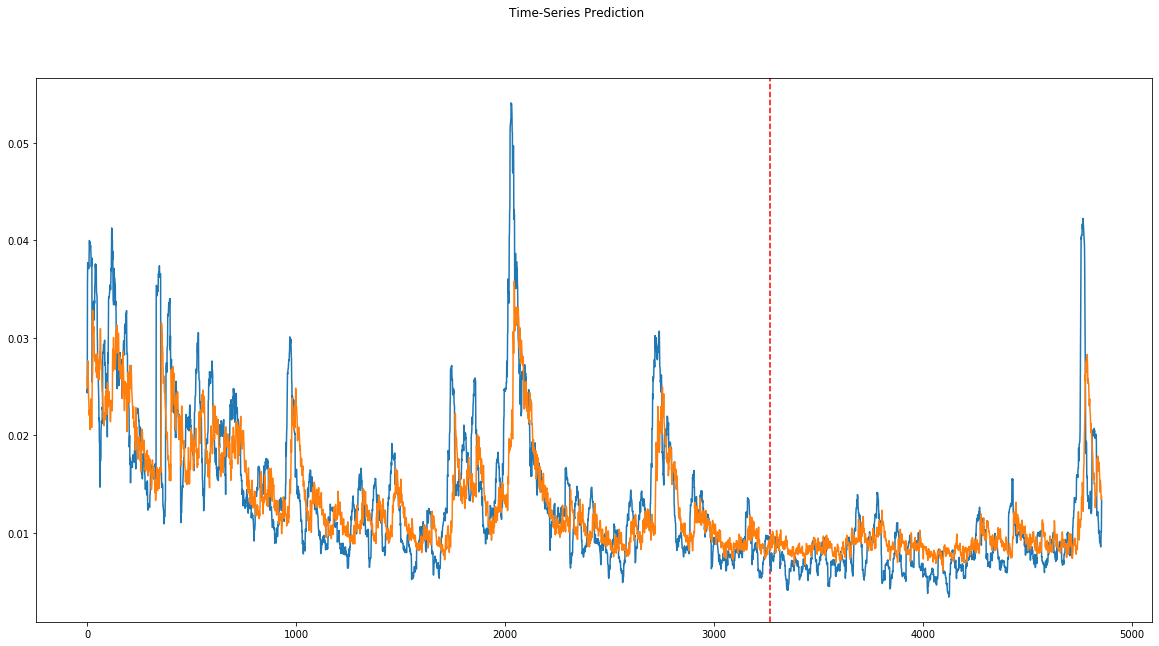

In [24]:
lstm.eval()
# print(dataX[0])
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

plt.figure(figsize=(20,10))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

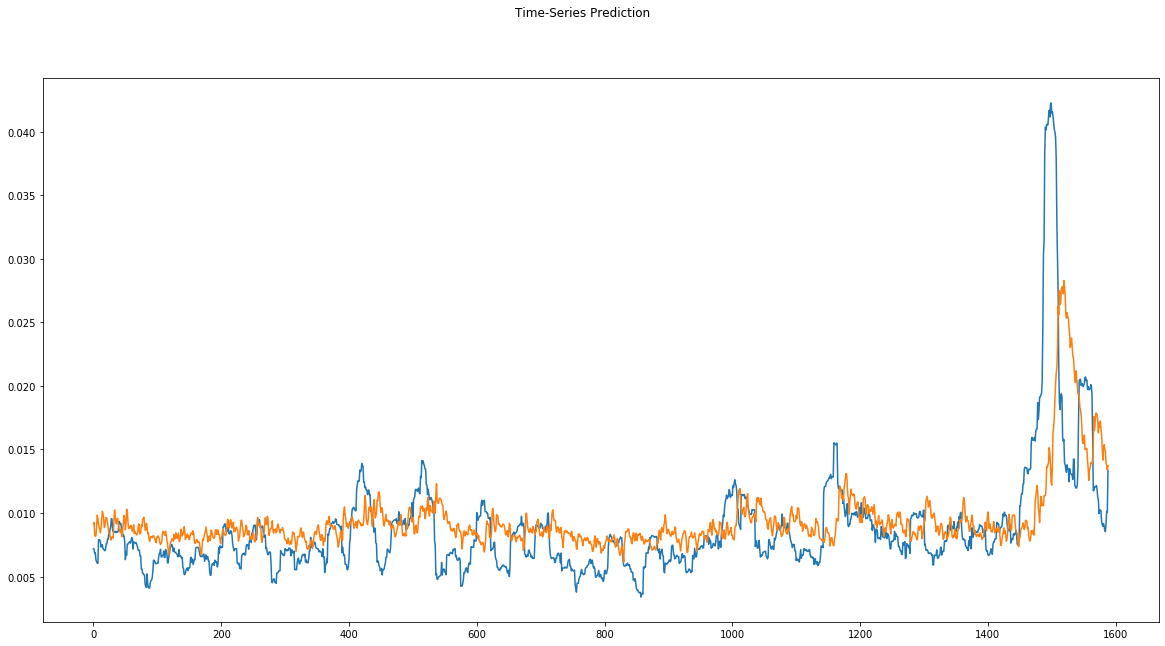

In [25]:

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(20,10))

plt.plot(dataY_plot[train_size:])
plt.plot(data_predict[train_size:])
plt.suptitle('Time-Series Prediction')
plt.show()

In [26]:
table = Error_stat(dataY_plot,data_predict,train_size)
table

,0,1,2,3
0,,Test,Train,Overall
1,MAE,[0.24675147],[0.37003303],[0.32968414]
2,MSE,[0.16850401],[0.3121894],[0.2651627]
3,HMAE,[0.24290605],[0.2573995],[0.25265574]
4,HMSE,[0.120283596],[0.13741052],[0.13180505]


In [ ]:

0	1	2	3
0		Test	Train	Overall
1	MAE	[0.24690297]	[0.40192413]	[0.35118744]
2	MSE	[0.16631322]	[0.33602592]	[0.2804803]
3	HMAE	[0.28336406]	[0.28193548]	[0.28240302]
4	HMSE	[0.1731199]	[0.15338053]	[0.15984082]

## EWMA+EGARCH

Epoch: 0, loss: 0.10048
Epoch: 20, loss: 0.02606
Epoch: 40, loss: 0.00495
Epoch: 60, loss: 0.00426
Epoch: 80, loss: 0.00400
Epoch: 100, loss: 0.00386
Epoch: 120, loss: 0.00383
Epoch: 140, loss: 0.00381
Epoch: 160, loss: 0.00380
Epoch: 180, loss: 0.00380


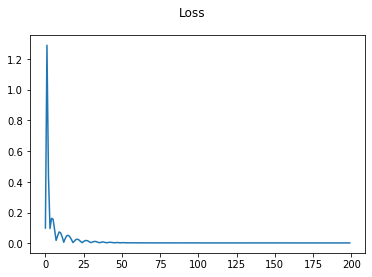

In [27]:
var_list = ['Volatility','KOSPI2 Index', 'egarch_cond_vol', 'egarch_std_resid', 
            'egarch_asymmetric','ewma_cond_vol', 'ewma_resid']
seq_length = 22

dataX,dataY,trainX,trainY,testX,testY = data_prepare(training_set,var_list, seq_length)
num_epochs = 200
learning_rate = 0.01
input_size = len(var_list)
hidden_size = seq_length*input_size
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.L1Loss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

loss_list = []


# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss_list.append(loss.item())
    loss.backward()
    
    optimizer.step()
    if epoch % 20 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        
plt.plot(loss_list)
plt.suptitle('Loss')
plt.show()

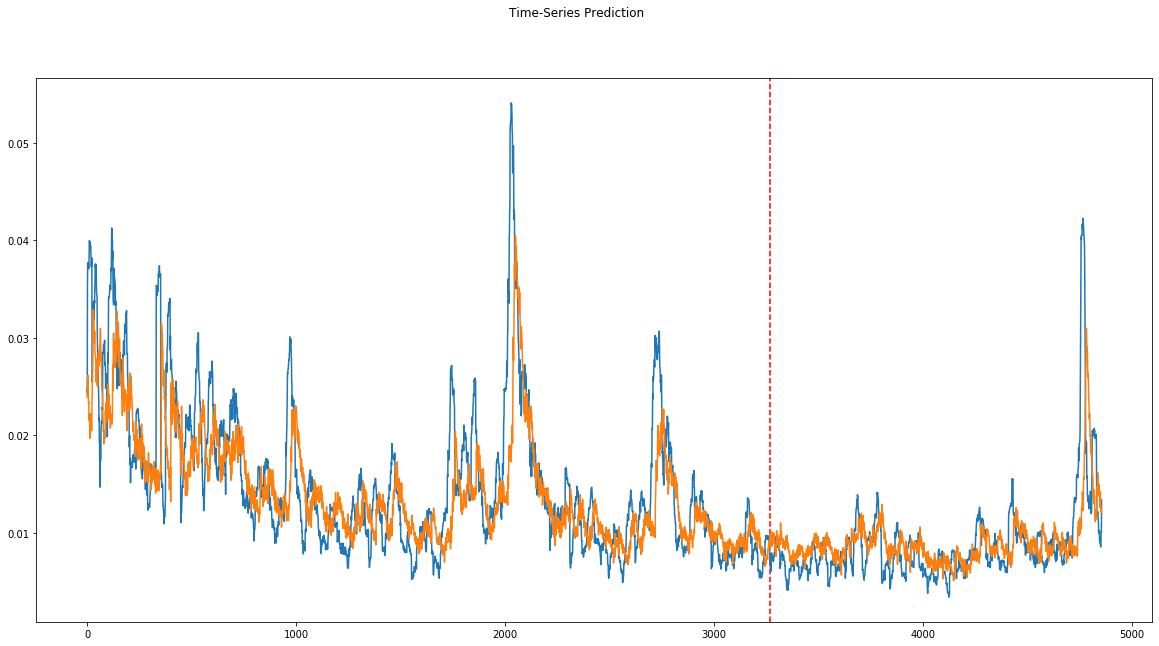

In [28]:
lstm.eval()
# print(dataX[0])
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

plt.figure(figsize=(20,10))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

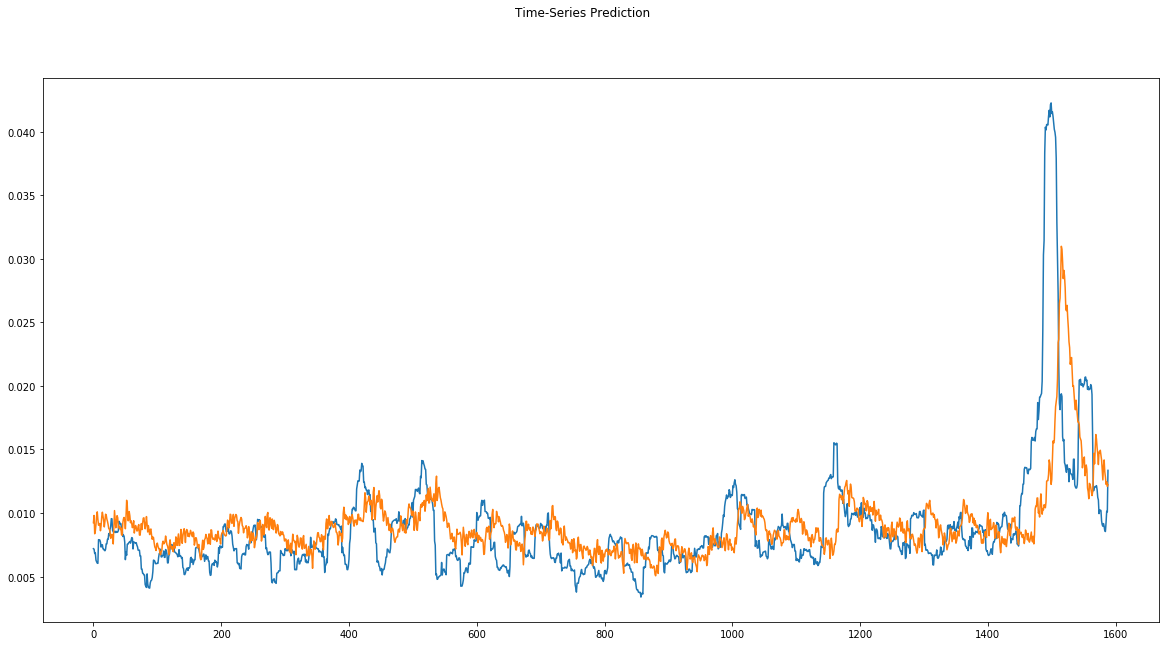

In [29]:

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(20,10))

plt.plot(dataY_plot[train_size:])
plt.plot(data_predict[train_size:])
plt.suptitle('Time-Series Prediction')
plt.show()

In [30]:
table = Error_stat(dataY_plot,data_predict,train_size)
table

,0,1,2,3
0,,Test,Train,Overall
1,MAE,[0.23998722],[0.37945703],[0.33380955]
2,MSE,[0.17399916],[0.32654887],[0.27662084]
3,HMAE,[0.24582253],[0.26501003],[0.25873065]
4,HMSE,[0.13570498],[0.14560458],[0.14236464]


## Garch

Epoch: 0, loss: 0.09106
Epoch: 20, loss: 0.00867
Epoch: 40, loss: 0.00395
Epoch: 60, loss: 0.00401
Epoch: 80, loss: 0.00389
Epoch: 100, loss: 0.00387
Epoch: 120, loss: 0.00386
Epoch: 140, loss: 0.00384
Epoch: 160, loss: 0.00383
Epoch: 180, loss: 0.00382


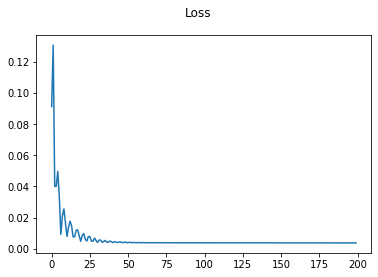

In [31]:
var_list = ['Volatility','KOSPI2 Index', 'garch_cond_vol','garch_resid']
seq_length = 22

dataX,dataY,trainX,trainY,testX,testY = data_prepare(training_set,var_list, seq_length)
num_epochs = 200
learning_rate = 0.01
input_size = len(var_list)
hidden_size = seq_length*input_size
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.L1Loss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

loss_list = []


# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss_list.append(loss.item())
    loss.backward()
    
    optimizer.step()
    if epoch % 20 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        
plt.plot(loss_list)
plt.suptitle('Loss')
plt.show()

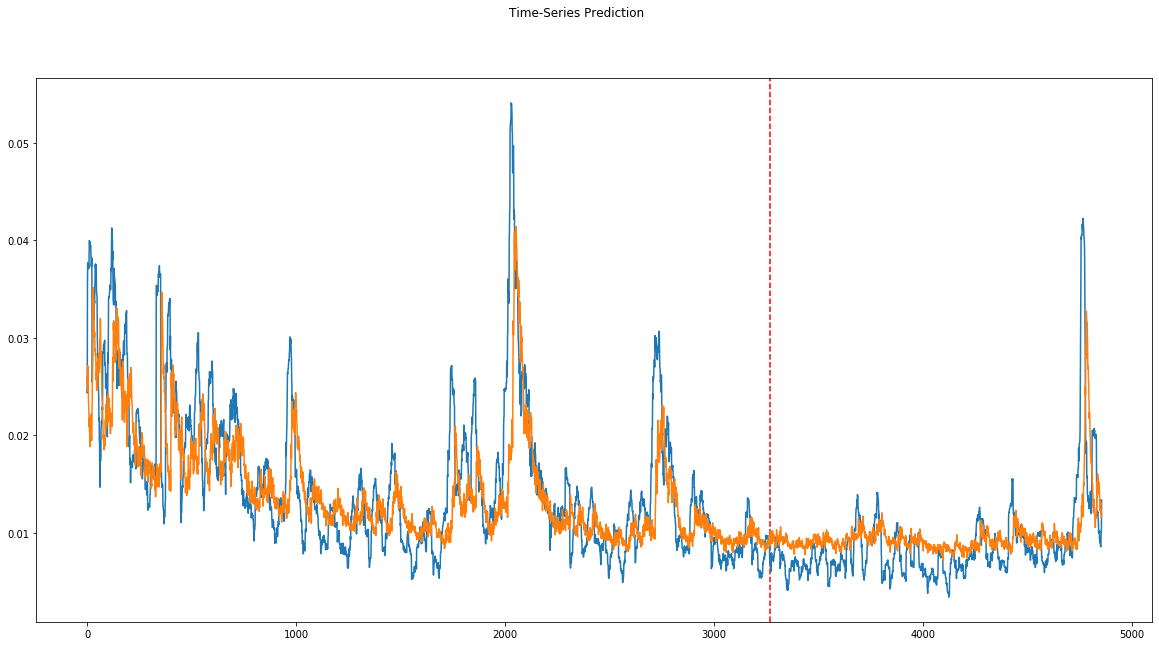

In [32]:
lstm.eval()
# print(dataX[0])
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

plt.figure(figsize=(20,10))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

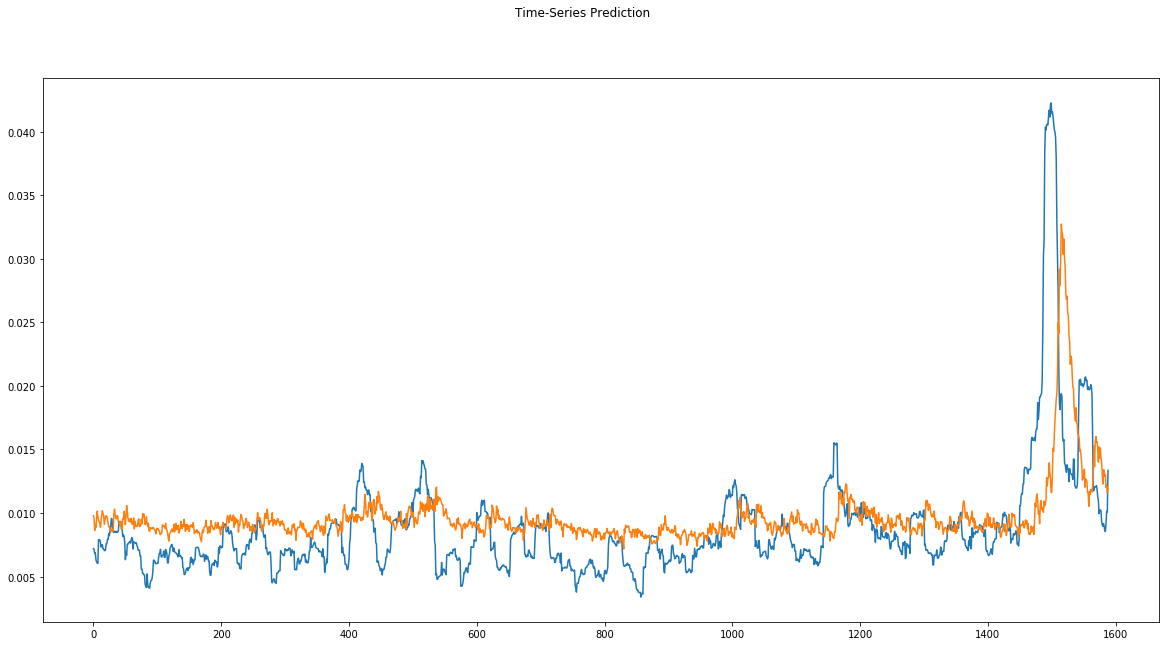

In [33]:

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(20,10))

plt.plot(dataY_plot[train_size:])
plt.plot(data_predict[train_size:])
plt.suptitle('Time-Series Prediction')
plt.show()

In [34]:
table = Error_stat(dataY_plot,data_predict,train_size)
table

,0,1,2,3
0,,Test,Train,Overall
1,MAE,[0.26489022],[0.37973112],[0.3421445]
2,MSE,[0.18785131],[0.33163458],[0.28457543]
3,HMAE,[0.25840786],[0.26342192],[0.26178062]
4,HMSE,[0.13972977],[0.14528136],[0.14346439]


## EGARCH

Epoch: 0, loss: 0.06917
Epoch: 20, loss: 0.02205
Epoch: 40, loss: 0.00611
Epoch: 60, loss: 0.00479
Epoch: 80, loss: 0.00423
Epoch: 100, loss: 0.00414
Epoch: 120, loss: 0.00411
Epoch: 140, loss: 0.00408
Epoch: 160, loss: 0.00406
Epoch: 180, loss: 0.00404


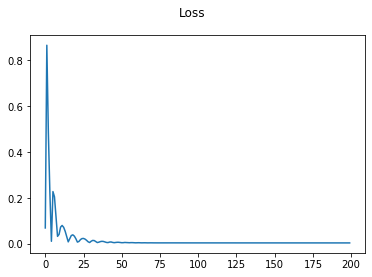

In [35]:
var_list = ['Volatility','KOSPI2 Index', 'egarch_cond_vol', 'egarch_std_resid', 'egarch_asymmetric']
seq_length = 22

dataX,dataY,trainX,trainY,testX,testY = data_prepare(training_set,var_list, seq_length)
num_epochs = 200
learning_rate = 0.01
input_size = len(var_list)
hidden_size = seq_length*input_size
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.L1Loss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

loss_list = []


# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss_list.append(loss.item())
    loss.backward()
    
    optimizer.step()
    if epoch % 20 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        
plt.plot(loss_list)
plt.suptitle('Loss')
plt.show()

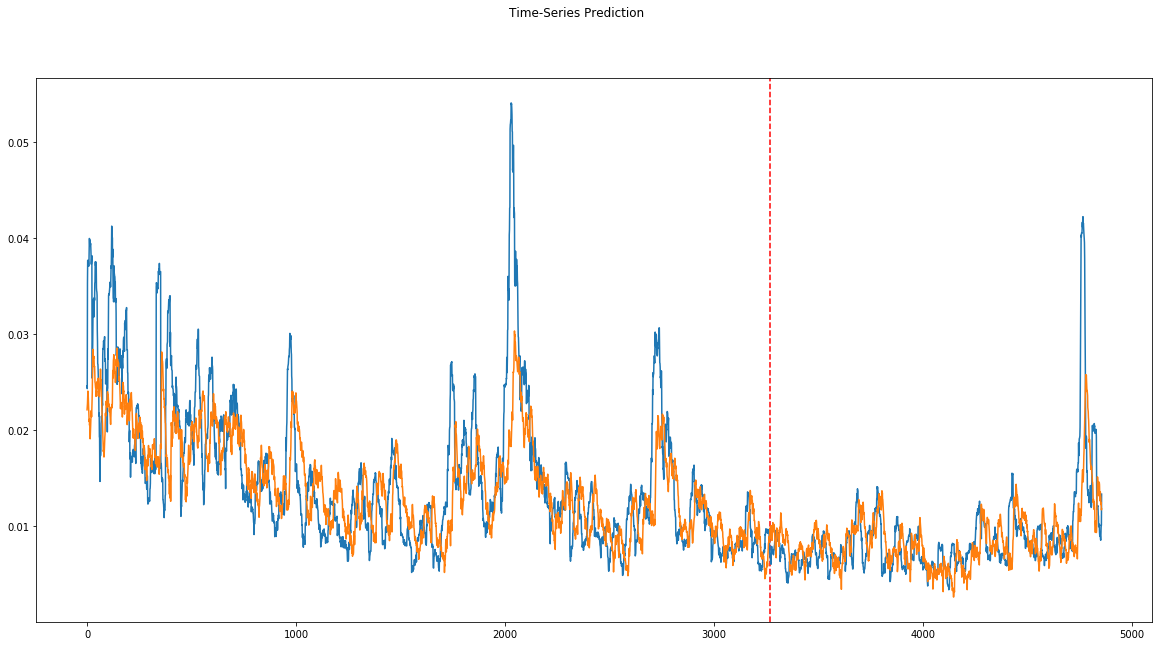

In [36]:
lstm.eval()
# print(dataX[0])
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

plt.figure(figsize=(20,10))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

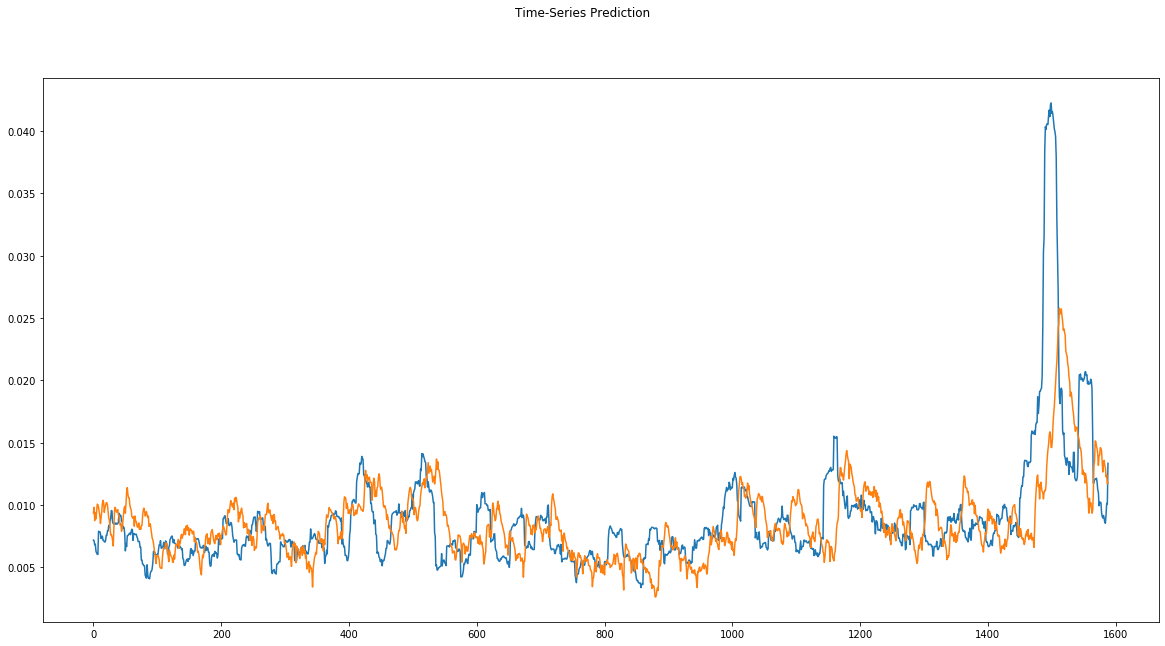

In [37]:

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(20,10))

plt.plot(dataY_plot[train_size:])
plt.plot(data_predict[train_size:])
plt.suptitle('Time-Series Prediction')
plt.show()

In [38]:
table = Error_stat(dataY_plot,data_predict,train_size)
table

,0,1,2,3
0,,Test,Train,Overall
1,MAE,[0.24690297],[0.40192413],[0.35118744]
2,MSE,[0.16631322],[0.33602592],[0.2804803]
3,HMAE,[0.28336406],[0.28193548],[0.28240302]
4,HMSE,[0.1731199],[0.15338053],[0.15984082]


## EWMA

Epoch: 0, loss: 0.05175
Epoch: 20, loss: 0.00979
Epoch: 40, loss: 0.00505
Epoch: 60, loss: 0.00396
Epoch: 80, loss: 0.00383
Epoch: 100, loss: 0.00382
Epoch: 120, loss: 0.00380
Epoch: 140, loss: 0.00379
Epoch: 160, loss: 0.00378
Epoch: 180, loss: 0.00377


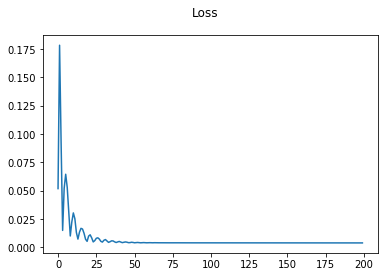

In [39]:
var_list = ['Volatility','KOSPI2 Index','ewma_cond_vol', 'ewma_resid']
seq_length = 22

dataX,dataY,trainX,trainY,testX,testY = data_prepare(training_set,var_list, seq_length)
num_epochs = 200
learning_rate = 0.01
input_size = len(var_list)
hidden_size = seq_length*input_size
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.L1Loss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

loss_list = []


# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss_list.append(loss.item())
    loss.backward()
    
    optimizer.step()
    if epoch % 20 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        
plt.plot(loss_list)
plt.suptitle('Loss')
plt.show()

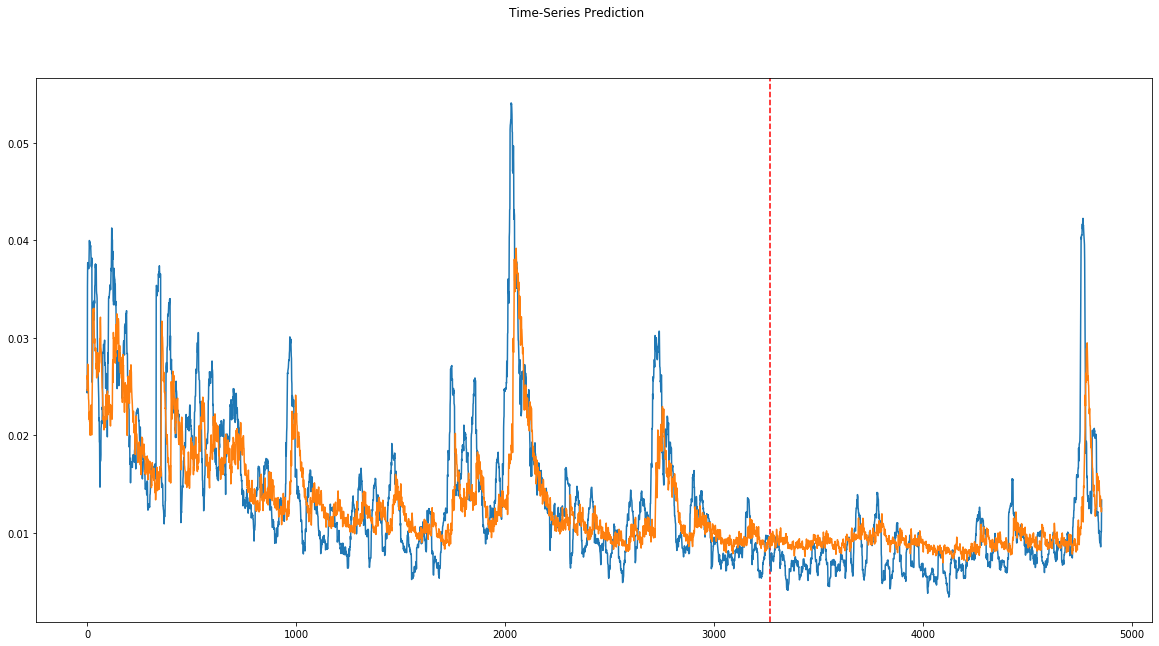

In [40]:
lstm.eval()
# print(dataX[0])
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

plt.figure(figsize=(20,10))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

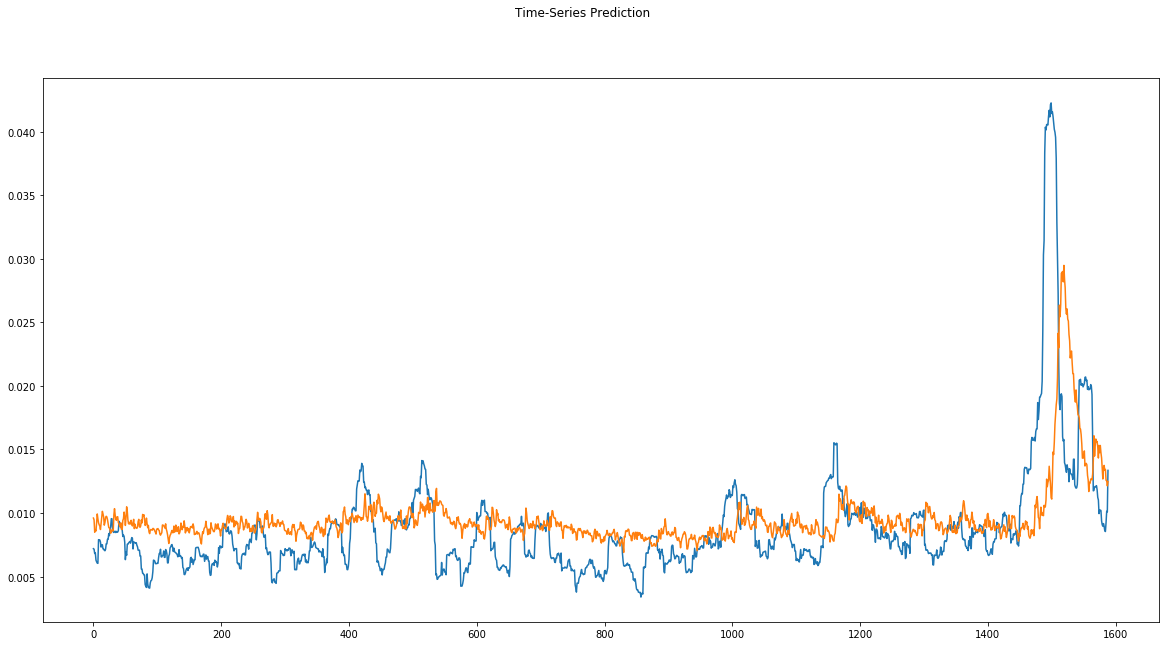

In [41]:

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(20,10))

plt.plot(dataY_plot[train_size:])
plt.plot(data_predict[train_size:])
plt.suptitle('Time-Series Prediction')
plt.show()

In [42]:
table = Error_stat(dataY_plot,data_predict,train_size)
table

,0,1,2,3
0,,Test,Train,Overall
1,MAE,[0.25781736],[0.37533113],[0.33686996]
2,MSE,[0.18250278],[0.32668734],[0.27949676]
3,HMAE,[0.25510752],[0.26116794],[0.25918412]
4,HMSE,[0.14165516],[0.14521924],[0.14405268]


## Single Model

Epoch: 0, loss: 0.04768
Epoch: 20, loss: 0.00841
Epoch: 40, loss: 0.00532
Epoch: 60, loss: 0.00504
Epoch: 80, loss: 0.00490
Epoch: 100, loss: 0.00482
Epoch: 120, loss: 0.00471
Epoch: 140, loss: 0.00458
Epoch: 160, loss: 0.00435
Epoch: 180, loss: 0.00467


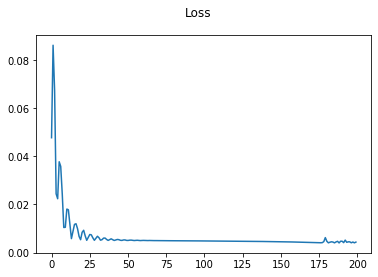

In [43]:
var_list = ['Volatility','KOSPI2 Index']
seq_length = 22

dataX,dataY,trainX,trainY,testX,testY = data_prepare(training_set,var_list, seq_length)
num_epochs = 200
learning_rate = 0.01
input_size = len(var_list)
hidden_size = seq_length*input_size
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.L1Loss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

loss_list = []


# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss_list.append(loss.item())
    loss.backward()
    
    optimizer.step()
    if epoch % 20 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        
plt.plot(loss_list)
plt.suptitle('Loss')
plt.show()

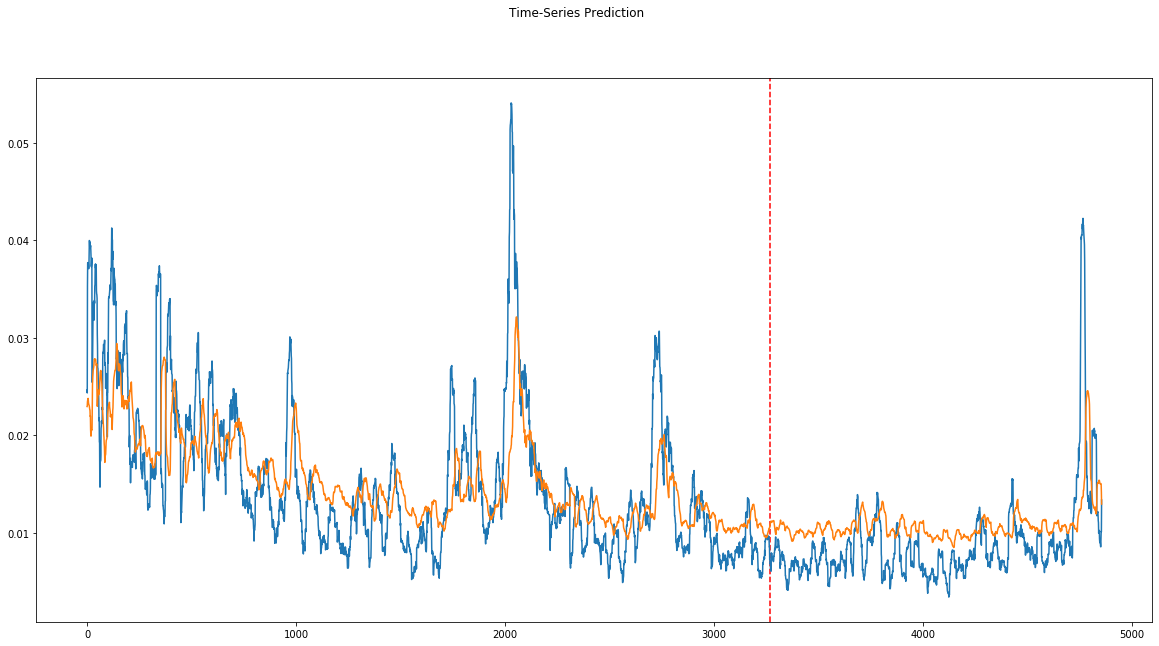

In [44]:
lstm.eval()
# print(dataX[0])
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

plt.figure(figsize=(20,10))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

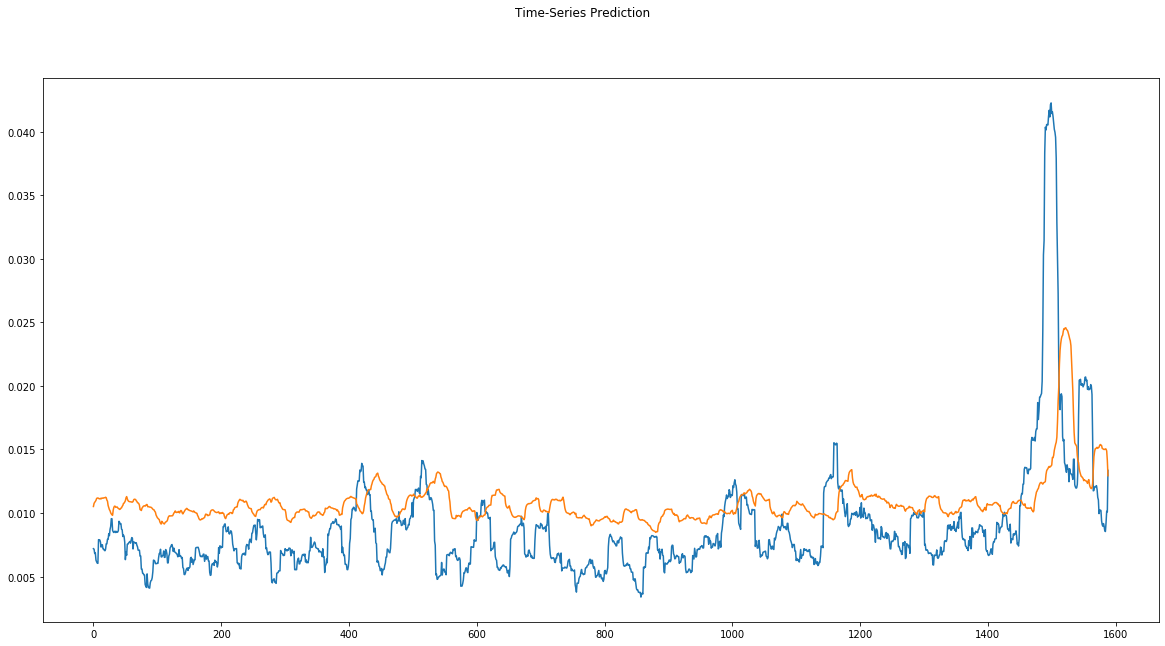

In [45]:

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(20,10))

plt.plot(dataY_plot[train_size:])
plt.plot(data_predict[train_size:])
plt.suptitle('Time-Series Prediction')
plt.show()

In [46]:
table = Error_stat(dataY_plot,data_predict,train_size)
table

,0,1,2,3
0,,Test,Train,Overall
1,MAE,[0.3450096],[0.41617462],[0.39288303]
2,MSE,[0.22414999],[0.3437136],[0.30458045]
3,HMAE,[0.3092717],[0.26811233],[0.2815837]
4,HMSE,[0.15354863],[0.12862787],[0.13678426]
